In [1]:
import do_mpc
import numpy as np
import matplotlib.pyplot as plt

from data.data_generation import data_generation
from src.model.dynamics_model import dynamics_model
from src.model.mpc_controller import mpc_controller
from src.model.mhe_estimator import mhe_estimator
from src.model.simulator import simulator
from src.util.question_selector import question_selector, benchmark1, benchmark2
from src.util.constants import *

constants.py: S=50, C=1000, and K=9


In [2]:
np.random.seed(seed=42)
# Obtain all configured modules and run the loop

phi, psi, ohm = data_generation()  # students, questions, involvements
model = dynamics_model(S, C, K)
mpc = mpc_controller(model)
mhe = mhe_estimator(model)
sim = simulator(model)
estimator = do_mpc.estimator.StateFeedback(model)

''' Use different initial state for the true system (simulator) and for MHE / MPC '''
x0_true = np.concatenate((phi[4], np.array([0])))
x0 = np.zeros(model.n_x).reshape((model.n_x, 1))                  # --> Shape = 10

# Initialize MPC, Sim and MHE
mpc.x0 = x0
sim.x0 = x0_true
mhe.x0 = x0
#estimator.x0 = x0

# Set initial guess for MHE/MPC based on initial state.
mpc.set_initial_guess()
#mhe.set_initial_guess()


data_generation() constructed student data with shape (50, 9) and questions data with shape (2000, 9)
dynamics_model(): model type is discrete and symvars are SX


C:\Users\Thomas\anaconda3\envs\LearningAnalytics\lib\site-packages\do_mpc\controller.py:760: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [3]:
%%capture
"""
Run MPC main loop:
"""
import os
result_path = './src/util/'
result_filename = 'results'
#result_filename = 'results_benchmarkRandom'
#result_filename = 'results_benchmarkIncreasing'

q_previous = x0_true
q_tracker = np.zeros((S, 2 * C), dtype=bool)

if True:#not os.path.exists(result_path + result_filename + '.pkl'):
    T_max = 800
    T_cumulative = 0
    for k in range(50):
        # Find optimal question
        u0_tilde = mpc.make_step(x0)

        #_w = u0_tilde[:K]        # [1,   1,   0, 0, 0, 0, 0, 0, 0]
        _h = u0_tilde[:K]     # [0.5, 0.2, 0, 0, 0, 0, 0, 0, 0]
        _T = u0_tilde[-1]        # 50

        # Question selector goes here
        #q_previous = u0_tilde

        # Simulate with process and measurement noise
        x_prev = sim.x0
        y_next = sim.make_step(u0_tilde,
                               w0=0.01 * np.random.randn(model.n_w, 1))
                                     #v0=0.01 * np.random.randn(model.n_v, 1)

        # Estimate the next knowledge status
        x0 = mhe.make_step(y_next)
        #x0 = estimator.make_step(y_next)


    '''
    # Plotting simulation data
    fig, ax, graphics = do_mpc.graphics.default_plot(sim.data, figsize=(9, 10))
    # sim_graphics.plot_results()
    graphics.plot_results()
    # ax[0].set_ylim(0.0, 1.1)
    plt.show()

    #save_dict(data_dict)
    do_mpc.data.save_results([sim, mpc, estimator], result_name=result_filename, result_path=result_path, overwrite=True)
    '''

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
mhe_graphics = do_mpc.graphics.Graphics(mhe.data)
sim_graphics = do_mpc.graphics.Graphics(sim.data)

In [5]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2,2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [6]:
%%capture
for g in [sim_graphics, mpc_graphics, mhe_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='x', axis=ax[0][0])
    g.add_line(var_type='_x', var_name='T_total', axis=ax[0][1])

    g.add_line(var_type='_u', var_name='h', axis=ax[1][0])
    g.add_line(var_type='_u', var_name='T', axis=ax[1][1])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    #g.add_line(var_type='_u', var_name='w', axis=ax[1])
    #g.add_line(var_type='_z', var_name='w', axis=ax[1][0])
    #g.add_line(var_type='_z', var_name='n_involved_skills', axis=ax[2][1])

ax[0,0].set_ylabel('x')
ax[0,1].set_ylabel('T_total')
ax[1,0].set_ylabel('h')
ax[1,1].set_ylabel('T')

for line_i in mpc_graphics.result_lines.full:
    line_i.set_linestyle('--')

for line_i in mhe_graphics.result_lines.full:
    line_i.set_alpha(0.4)
    line_i.set_linewidth(6)

Free response model

[[0.4]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [1. ]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      695
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      690

Total number of variables............................:      155
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      110
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objectiv

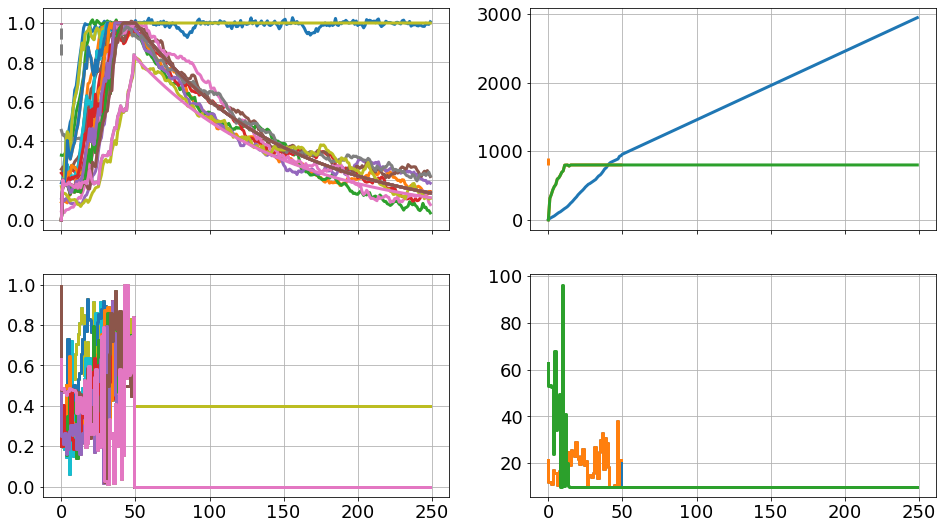

In [16]:
#u0 = np.zeros((10,1))
#u0[0] += 0.4
#u0[-1] += 10
#for i in range(200):
    #sim.make_step(u0)
#    y0 = sim.make_step(u0, w0=0.01*np.random.randn(model.n_w,1))
#    print(y0)
#    x0 = mhe.make_step(y0)

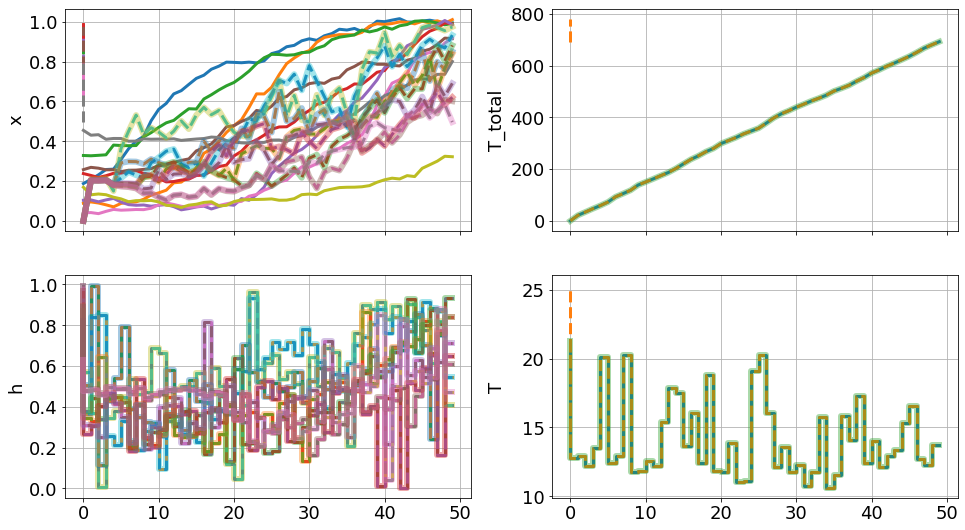

In [7]:
sim_graphics.plot_results()
mpc_graphics.plot_results()
mhe_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
mpc_graphics.reset_axes()
mhe_graphics.reset_axes()
# Show the figure:
fig

In [8]:
fig.savefig("results.png")

In [31]:
fig.clf()
#sim.reset_history()
#sim.x0 = x0_true
#mpc.reset_history()

In [ ]:
def day_of_the_week(value):
    if value % 7 == 1:
        return 'mon'
    elif value % 7 == 2:
        return 'tue'
    elif value % 7 == 3:
        return 'wed'
    elif value % 7 == 4:
        return 'thu'
    elif value % 7 == 5:
        return 'fri'
    elif value % 7 == 6:
        return 'sat'
    elif value % 7 == 0:
        return 'sun'


In [ ]:
for i in range(50):
    # if day_of_the_week(i) == 'tue' or day_of_the_week(i) == 'thu' or day_of_the_week(i) == 'sat'or day_of_the_week(i) == 'sun':
    #   u0 = np.zeros((19,1))
    #    u0[-1] = 24
    # else:
    u0 = mpc.make_step(x0)
    x0 = sim.make_step(u0)
    #print(i)

In [ ]:
sim.data._aux

In [ ]:
# Plot predictions from t=0
#mpc_graphics.plot_predictions(t_ind=5)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

In [ ]:
sim.data._z